# Markovitz Portfolio Selection

In [1]:
using DataFrames
using CSV
using Plots
using Statistics
using Dates
using SymPy
using JuMP
using COSMO

In [2]:
# Load the data and visualize first rows
data = DataFrames.DataFrame(CSV.File("data/all_stocks_5yr.csv"));
print(first(data, 5))
stocks = Dict()
for (key, subdf) in pairs(groupby(data, :Name))
    stocks[key.Name] = copy(subdf)
end

5×7 DataFrame
 Row │ Date        Open      High      Low       Close    Volume     Name     
     │ Date        Float64?  Float64?  Float64?  Float64  Float64?   String15 
─────┼────────────────────────────────────────────────────────────────────────
   1 │ 2012-08-13     92.29     92.59     91.74    92.4   2.07539e6  MMM
   2 │ 2012-08-14     92.36     92.5      92.01    92.3   1.84348e6  MMM
   3 │ 2012-08-15     92.0      92.74     91.94    92.54  1.9834e6   MMM
   4 │ 2012-08-16     92.75     93.87     92.21    93.74  3.39514e6  MMM
   5 │ 2012-08-17     93.93     94.3      93.59    94.24  3.06951e6  MMM

In [3]:
# Get a fixed order of the stocks
#stock_names = collect(keys(stocks));
stock_names = unique(keys(stocks));

# randomly select some stocks to reduce the amount of data
N_stocks = 110
stocks_selected = rand(stock_names, N_stocks);

# delete some stocks
for name in stock_names
    if name in stocks_selected
        continue
    end
    delete!(stocks, name)
end;

# adapt stock_names array after stock deletion
stock_names = collect(keys(stocks));
N_stocks = length(stock_names);

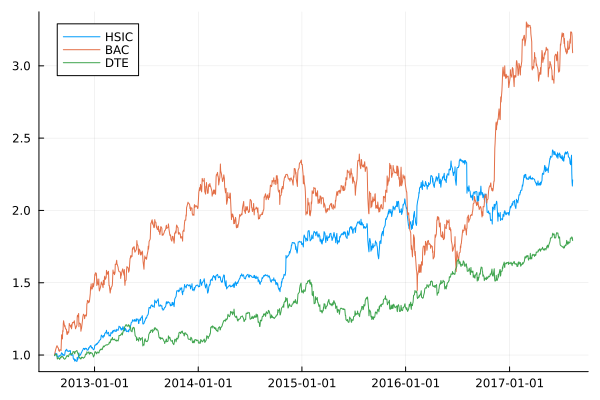

In [4]:
# Visualize evolution of stock changes for some examples
plot(stocks[stock_names[1]].Date, stocks[stock_names[1]].Close / first(stocks[stock_names[1]].Close); label=stock_names[1], legend=:topleft)
plot!(stocks[stock_names[2]].Date, stocks[stock_names[2]].Close / first(stocks[stock_names[2]].Close); label=stock_names[2])
plot!(stocks[stock_names[3]].Date, stocks[stock_names[3]].Close / first(stocks[stock_names[3]].Close); label=stock_names[3])

## Calculate Statistical Quantities

In [5]:
# Calculate the daily change
for k in keys(stocks)
   select!(stocks[k], :Name, :Date, :Open, :Close, [:Open,:Close] => ByRow((o,c) -> c/o) => :Change)
end

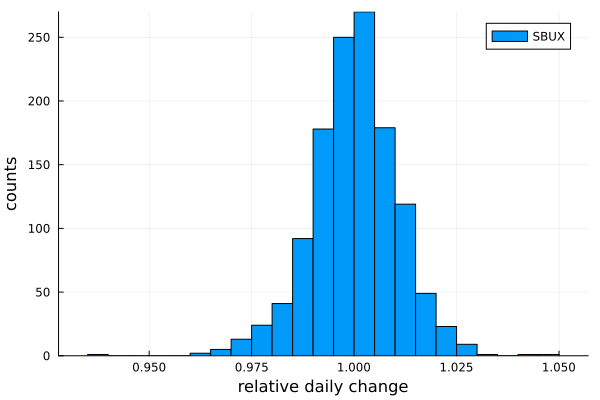

In [6]:
# plot the daily changes for an example in a histogram
stock_number = 4
histogram(filter(x -> x !== missing, stocks[stock_names[stock_number]].Change), label=stock_names[stock_number])
xlabel!("relative daily change")
ylabel!("counts")

In [7]:
# ===============================================================================
# Compute the average of the daily changes for each stock
# Hint: As done for plotting the histogram above you should filter out missing values
avg = zeros(N_stocks)

for (k,name) in enumerate(stock_names)
   avg[k] = mean(filter(x -> x !== missing, stocks[name].Change))
end

# ===============================================================================

In [8]:
# define a function to compute the covariance of two distributions s1 and s2
# s1, s2: input arrays containing stock changes
function covariance(s1, s2)

    l = min(length(s1), length(s2))
    # make sure that both stocks have data at the same day!
    gi = filter(i -> s1[i] !== missing && s2[i] !== missing, 1:l) # good indices
    l = length(gi)
    
    # ===============================================================================
    # Compute the covariance
    m1 = sum(s1[gi]) / l
    m2 = sum(s2[gi]) / l
    covariance = sum((s1[gi] .- m1) .* (s2[gi] .- m2)) / (l-1)
    # ===============================================================================
    return covariance
end

covariance (generic function with 1 method)

In [9]:
# =============================================================================================
# Compute the covariance matrix

covar = zeros(N_stocks ,N_stocks)
for i=1:N_stocks , j=1:N_stocks 
    covar[i,j] = covariance(stocks[stock_names[i]].Change, stocks[stock_names[j]].Change)
end
# =============================================================================================

In [10]:
# =============================================================================================
# Compute the Variance for each stock
# Hint: As done for plotting the histogram above you should filter out missing values
variance = zeros(N_stocks)

for (k,name) in enumerate(stock_names)
    changes = filter(x -> x !== missing, stocks[name].Change)
    variance[k] = covariance(changes, changes)
end
# =============================================================================================

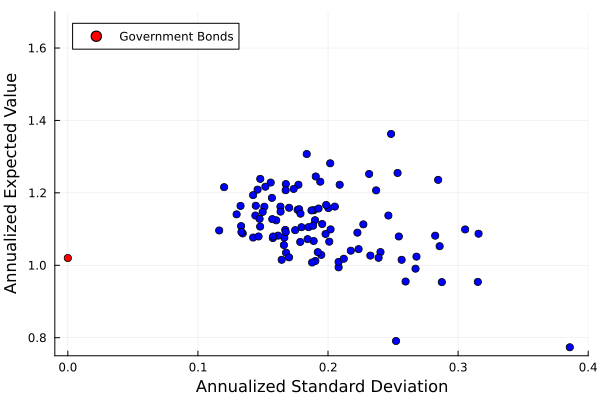

In [11]:
# Show annualized standard deviation and average
fig = scatter([], [], xlabel="Annualized Standard Deviation", ylim=(0.75,1.7), xlim=(-0.01,.4), ylabel="Annualized Expected Value", labels=:none, legend=:topleft)
for k=1:N_stocks 
    scatter!([sqrt(variance[k]) * sqrt(252)], [avg[k]^252], labels=:none, markercolor=:blue)
end
scatter!([0.0], [1.02], label="Government Bonds", markercolor=:red)

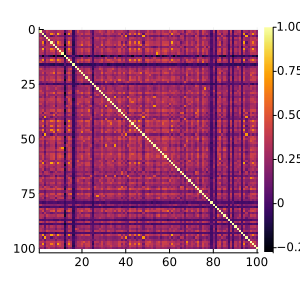

In [12]:
# Compute correlation between stocks and visualize in a heatmap

corre = zeros(N_stocks,N_stocks)
for i=1:N_stocks , j=1:N_stocks
    corre[i,j] = covar[i,j] / (sqrt(variance[i])*sqrt(variance[j]))
end

heatmap(corre, yflip=true, aspect_ratio=:equal, size=(300,300))

## Optimize Portfolio

In [13]:
# =============================================================================================
# Optimize your portfolio by using the COSMO Optimizer (Quadratic solver).
# Choose your favourite form of the optimization problem (lecture 5, slide 21).
# Depending on your choice, try different values for the minimum expected change, the maximum variance 
# or the risk aversion parameter

q = 100

model = Model(COSMO.Optimizer)
@variable(model, w[1:N_stocks])
@constraint(model, ones(N_stocks)'*w == 1)
@constraint(model, w .>= 0)
@objective(model, Max, avg'*w - q * w'*covar*w)

#@constraint(model, ones(N_stocks)'*w == 1)
#@constraint(model, w'*covar*w .<= 10)
#@constraint(model, w .>= 0)
#@objective(model, Max, avg'*w)

optimize!(model)
w_best = value.(w[1:N_stocks]);

# =============================================================================================

------------------------------------------------------------------
          COSMO v0.8.8 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{100},
          constraints: A ∈ R^{101x100} (200 nnz),
          matrix size to factor: 201x201,
          Floating-point precision: Float64
Sets:     Nonnegatives of dim: 100
          ZeroSet of dim: 1
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: true, tol: 2.0
Setup Time: 2999.89ms

Iter:	Objective:	Primal Res:

In [14]:
indices = sortperm(w_best, rev=true);
println(w_best[indices[1:5]],"\n",stock_names[indices[1:5]])

[0.14071708654213186, 0.13340701486896223, 0.07945411179985454, 0.06739781317330684, 0.06400528162682192]
Any[String15("XL"), String15("AON"), String15("WBA"), String15("MMM"), String15("ICE")]


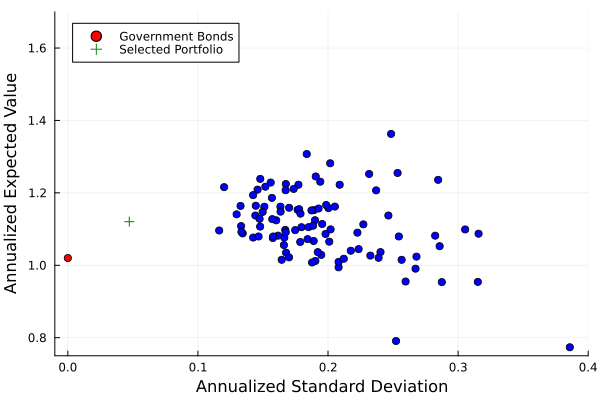

In [15]:
#plot your optimized portfolio and see how your portfolio performs in comparison to single stock investments

fig = scatter([], [], xlabel="Annualized Standard Deviation", ylim=(0.75,1.7), xlim=(-0.01,.4), ylabel="Annualized Expected Value", labels=:none, legend=:topleft)
for k=1:N_stocks
    scatter!([sqrt(variance[k]) * sqrt(252)], [avg[k]^252], labels=:none, markercolor=:blue)
end
scatter!([0.0], [1.02], label="Government Bonds", markercolor=:red)

risk = w_best'*covar*w_best
ret = avg'*w_best
scatter!([sqrt(risk) * sqrt(252)], [ret^252], labels="Selected Portfolio", markercolor=:green, marker=:+, markersize=5,linewidth=20)


# Exercise 12.2: The inverted pendulum

**Remark to generate the animations**
* Install the ffmpeg package, e.g. by conda install ffmpeg!!
* Beware that existing gifs might not be overwritten automatically. Make sure to always give a new name to the `animate_pendulum` function or delete the existing file.


In [16]:
using Luxor

import LinearAlgebra
LA = LinearAlgebra;

In [158]:
# define some global variables

# pendulum mass in kg
const m = 2
# cart mass in kg
const c = 8
# pole length in m
const l = 0.5
# earth acceleration in m/s²
const g = 9.81

# number of time steps for prediction horizion in MPC
T = 50
# length of time steps in s
Δt = 0.03
# time discount to weight objective function different depending on the amount of time passed
time_discount = 0.1

# number of variables of interest in optimization problem: 4 state space variables + 1 control
n = 5
# number of constraints in optimization problem
k = 4;

In [159]:
# Function for plotting pendulum animation
# Needs the ffmpeg package!! and a folder tmp
# Beware that existing gifs might not be overwritten automatically.
# Make sure to always give a new name or delete the existing
# p: array of cart positions for all times
# θ: array of pendulum positions for all times
# name: name of gif-file containing the animation
function animate_pendulum(p, θ, name)
    nt = length(p)

    # Create the "tmp" directory if it doesn't exist
    if !isdir("tmp")
        mkdir("tmp")
    end

    # iterate over all times and generate a png per time step
    for i = 1:nt
        @png begin
            background("white")
            factor = 350
            p1 = Point(p[i] * factor, 0)
            p2 = Point(sin(θ[i]) * factor * l, -cos(θ[i]) * factor * l) + p1
            origin()
            setline(10)
            sethue("red")
            line(p1, p2, :stroke)
            sethue("gold")
            line(Point(-1500, 0), Point(1500, 0), :stroke)
            sethue("black")
            Luxor.box(p1, 80, 40, :fill)
            circle(p2, 20, :fill)
            preview()
        end 2000 600 "tmp/" * name * "_" * lpad(i, 2, "0") * ".png"
    end

    # combine png images to gif
    loadpath = "tmp/" * name * "_"
    run(`ffmpeg -y -framerate 15.1515 -i $loadpath"%02d.png" "$name.mp4"`)

    # # Provide the full path to ffmpeg executable
    # ffmpeg_path = "C:\ffmpeg\bin\ffmpeg.exe"  # Change this to the actual path

end


animate_pendulum (generic function with 1 method)

## Exercise 12.2b: Pendulum simulation

\begin{align*}
\vec x_{t+1} = A_t \vec x_t + \vec b_t  u_t + \vec c_t\\
A_t = \begin{pmatrix}
1 & 0 & \Delta t & 0\\
0 & 1 & 0  & \Delta t\\
0 & 0 & 1  & 0\\
0 & 0 & 0  & 1
\end{pmatrix}\\
\vec b_t = \begin{pmatrix}
\Delta t \frac{-\cos(\theta_t)}{l(c+m \sin^2(\theta_t))} \frac{\Delta t}{2}\\
\frac{\Delta t} {(c+m \sin^2(\theta_t))} \frac{\Delta t}{2}\\
\Delta t \frac{-\cos(\theta_t)}{l(c+m \sin^2(\theta_t))}\\
\frac{\Delta t} {(c+m \sin^2(\theta_t))}
\end{pmatrix}\\
\vec{c}_t = 
\begin{pmatrix}
\Delta t \frac{(c+m) g \sin(\theta_t)-m l \sin(\theta_t) \cos(\theta_t) \dot{\theta}_t^2}{l (c+m*sin^2(\theta))} \frac{\Delta t}{2}\\
\Delta t \frac{-m g \sin(\theta_t) \cos(\theta_t)+m l \sin(\theta_t) \dot{\theta}_t^2}{c+m \sin^2(\theta_t)} \frac{\Delta t}{2}\\
\Delta t \frac{(c+m) g \sin(\theta_t)-m l \sin(\theta_t) \cos(\theta_t) \dot{\theta}_t^2}{l (c+m*sin^2(\theta))}\\
\Delta t \frac{-m g \sin(\theta_t) \cos(\theta_t)+m l \sin(\theta_t) \dot{\theta}_t^2}{c+m \sin^2(\theta_t)}
\end{pmatrix}
\end{align*}



In [95]:
# returns the quantities needed to calculate x_t+1 from time x_t and u_t
function At_bt_ct(θ,dθ)
    # acceleration linear in xt
    ddθ_fixed = Δt * ((c+m)*g*sin(θ)-m*l*sin(θ)*cos(θ)*(dθ^2)) / (l*(c+m*sin(θ)^2))
    ddp_fixed = Δt * (-m*g*sin(θ)*cos(θ)+m*l*sin(θ)*dθ^2) / (c+m*sin(θ)^2)
    
    # acceleration linear in u
    ddθ_u = Δt * (-cos(θ)) / (l*(c+m*sin(θ)^2))
    ddp_u = Δt / (c+m*sin(θ)^2)
    
    At = zeros(4,4)
    bt = zeros(4)
    ct = zeros(4)
    
    # ====================================================================================================
    # Construct the matrix A and the vectors bt and ct 
    
    At = [1 0 Δt 0;
         0 1 0  Δt;
         0 0 1  0;
         0 0 0  1];
    ct = [ddθ_fixed * Δt * 0.5; ddp_fixed * Δt * 0.5; ddθ_fixed; ddp_fixed]
    bt = [ddθ_u * Δt * 0.5; ddp_u * Δt * 0.5; ddθ_u; ddp_u]
    
    # ====================================================================================================
    
    return At, bt, ct
end

At_bt_ct (generic function with 1 method)

In [96]:
# simulate the pendulum movement
# x0: initial state vector
# u: array of control for each time step
# xt: array with state vector for each time step
function simulate_pendulum(x0,u)
    x_new = copy(x0)
    
    # number of time steps extracted from the length of control vector
    nt = length(u)
    xt = Vector(undef, nt)
    
    # iterate over time steps
    for t in 1:nt
        x = x_new
        At, bt, ct = At_bt_ct(x[1],x[3])
        x_new = At*x + bt*u[t] + ct
        xt[t] = x_new
    end
    return xt
end

simulate_pendulum (generic function with 1 method)

In [97]:
# set number of time steps of size Δt for which to simulate pendulum movement
time_sim = 200
x_arr = simulate_pendulum([0.75*pi,0,0,0],zeros(time_sim));

In [22]:
p_initial = map(x->x[2],x_arr)
θ_initial = map(x->x[1],x_arr)

animate_pendulum(p_initial,θ_initial,"pendulum")

ffmpeg version 2024-01-07-git-90bef6390f-full_build-www.gyan.dev Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.2.0 (Rev10, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --pkg-config=pkgconf --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libuavs3d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxvid --enable-libaom --enable-libjxl --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --e

Process(`ffmpeg -framerate 15 -i tmp/pendulum_%02d.png pendulum.mp4`, ProcessExited(0))

## Exercise 12.2d: Model predictive control

From the lecture we know the problem definition where we want to minimize the kinetic energy of the system (carriage + pendulum) and maximize the potential energy of the pendulum:

\begin{align*}
      \text{Kinetic Energy:} & \quad \begin{aligned}[t]
          e_{kin,kart}(\vec x) &= \frac{1}{2} c \dot p^2\\
          e_{kin,pend}(\vec x) &= \frac{1}{2} m \Big[(\dot p + l \color{red}{\sin(\theta)} \dot\theta)^2 + ( l \color{red}{\cos(\theta)} \dot\theta)^2 \Big]
        \end{aligned}\\
    \text{Potential Energy:} & \quad e_{\mathrm{pot}}(\vec x) = m\, l\, \color{red}{\cos(\theta)}\\
    &f_{\mathrm{state}}(\vec x_t) = \tilde e_{\mathrm{kin,cart}}(\vec x_t) + \tilde e_{\mathrm{kin,pend}}(\vec x_t) - \tilde e_{\mathrm{pot}}(\vec x_t)
  \end{align*}
  
 To ensure that the objective $f_{\mathrm{state}}(\vec x_t)$ is a convex function we have to replace the trigonometric functions $\cos$ and $\sin$ (red terms). We use a simulation run of the current control flow and the pendulum dynamics to generate a series of $\theta$ and $p$. We use those values in order to fix and approximate the $\cos$ and $\sin$ terms before optimizing $x_t$ and $u_t$. We recompute the control flow after each time step to keep the deviations between this approximation and reality as small as possible. 
 
As you might have noticed the potential energy that would lead to an upright pendulum is no longer dependent on $\theta$ or $p$, at least not the $\theta$ and $p$ that we optimize over.
To make the approximation work we have to introduce additional incentives. The original $e_{\mathrm{pot}}(\vec x) = m\, l\, \cos(\theta)$ would be maximized for $\theta = 0$. We therefore introduce $\theta^2$ as part of our objective:

\begin{align*}
    \min_{\substack{\vec u_0,\dots \vec u_{T-1},\\\vec x_1,\dots, \vec x_T}} \quad & \sum_{t=1}^{T} \left[ f_{\mathrm{state}}(\vec x_t) + \vec u_t^\top R \vec u_t + \theta_t^2\right]\\
  \end{align*}
  
 Additionally we would like to keep the pendulum centered to the screen. We therefore also require $p$ to be close to 0. Hence, we add the term $p^2$:
 
 \begin{align*}
    \min_{\substack{\vec u_0,\dots \vec u_{T-1},\\\vec x_1,\dots, \vec x_T}} \quad & \sum_{t=1}^{T} \left[ f_{\mathrm{state}}(\vec x_t) + \vec u_t^\top R \vec u_t + \theta_t^2+p_t^2\right]\\
  \end{align*}
  
Not all conditions are equally important at all points in time. For example: we want to use fast movement that is rich in kinetic energy to swing the pendulum upright in the beginning, but use only small movements to hold it there. We therefore also introduce a time series discount factor $\gamma$:

\begin{align*}
    \min_{\substack{\vec u_0,\dots \vec u_{T-1},\\\vec x_1,\dots, \vec x_T}} \quad & \sum_{t=1}^{T} \left[ (f_{\mathrm{state}}(\vec x_t) + \vec u_t^\top R \vec u_t + p_t^2)\cdot \gamma t +\theta_t^2\right]\\
  \end{align*}
  
This objective will be expressed by $\tilde{x_T^\top} Q \tilde{x_T}$ with the cost matrix $Q$ and
\begin{align*}
\tilde{\vec x}_T = \begin{pmatrix}
\theta_1\\
p_1\\
\dot{\theta_1}\\
\dot{p_1}\\
u_1\\
\theta_2\\
p_2\\
\vdots\\
\dot{\theta_T}\\
\dot{p_T}\\
u_T
\end{pmatrix}
\end{align*}.

This means

\begin{align*}
    \sum_{t=1}^{T} \left[ (f_{\mathrm{state}}(\vec x_t) + \vec u_t^\top R \vec u_t + p_t^2)\cdot \gamma t +\theta_t^2\right] =  \tilde{x_T^\top} Q \tilde{x_T} \\
  \end{align*}


In [24]:
unicodeplots()
using SparseArrays

In [39]:
using PyPlot

In [138]:
time_discount

0.1

In [180]:
# input is the state and the previously computed control u
# output is the control in this period
function mpc_pendulum_policy(x0,u_old)
      
    xt = simulate_pendulum(x0,u_old)
   
    # construct Matrix A_tilde and b_tilde for the equality constraints

    # kronecker product of two matrices --> new matrix has size = (T*k,T*n)
    A_tilde = kron(Matrix{Float64}(LA.I,T,T), -Matrix{Float64}(LA.I, k, n))
    b_tilde = zeros(k*T)
    
    b_tilde[1:length(x0)] = -x0 # Set first elements of b_tilde with x0
    
    for t=1:T-1
        # calculate At, bt and ct for each time step
        A_tmp, b_tmp, c_tmp = At_bt_ct(xt[t][1],xt[t][3])
        # construct Matrix A_tilde and b_tilde
        A_tilde[(t*k)+1:(t+1)*k,((t-1)*n)+1:t*n] = hcat(A_tmp,b_tmp)
        b_tilde[(t*k)+1:(t+1)*k] = -c_tmp
    end
    # PyPlot.spy(A_tilde)
    # PyPlot.plt.axis("off")
    
    #calculate the cost matrix Q 
    Q = zeros(n*T,n*T)
    for t=1:T-1
        θ = xt[t][1]
        c = cos(θ)
        s = sin(θ)

        t_tilde = 2*t^0.8
        
        #Our first objective is to get the pendulum upright and then hold that position in the centre of the line with at best not movement
        #not all objectives are similar important over time. time_discount*t enables us to reweight costs based on the passage of time.
        #make the pendulum upright and centered
        Q[((t-1)*n)+1,((t-1)*n)+1] = 100
        # Q[((t-1)*n)+2,((t-1)*n)+2] = time_discount^t
        Q[((t-1)*n)+2,((t-1)*n)+2] = time_discount*t_tilde
        
        #minimize kinetic energy in the system
        # ============================================================================================
        # fill the matrix Q with the terms of the objective function that are representing the kinetic
        # energy ot the system
        Q[((t-1)*n)+3,((t-1)*n)+3] = (0.5*m*l*l*(c*c+s*s))*time_discount*t
        Q[((t-1)*n)+4,((t-1)*n)+4] = (0.5*c+0.5*m)*time_discount*t
        Q[((t-1)*n)+3,((t-1)*n)+4] = (l*m*s)*time_discount*t
        # ============================================================================================
        
        #punish for large control values, if zero we might break the pendulum simulation, but you are encouraged to experiment
        Q[((t-1)*n)+5,((t-1)*n)+5] = 0.001
    end
    PyPlot.spy(Q)
    
    # ============================================================================================
    # setup the optimization problem and solve it using the COSMO solver --> simply exchange 
    # SCS.Optimizer by COSMO.Optimizer during model creation
    # define the objective and constraints using the JuMP package
    # model = Model(with_optimizer(COSMO.Optimizer));

    model = Model(COSMO.Optimizer)
    @variable(model, x[1:n*T]);
    @constraint(model, A_tilde * x .== b_tilde);#
    
    @objective(model, Min, x' * Q * x )
    optimize!(model)
    
    # extract the sequence of control values from the solution
    u_new = zeros(T)
    
    xt_ut = value.(x)
    u_new = [xt_ut[i] for i=5:5:T*5]
    # ============================================================================================
    return u_new
end

mpc_pendulum_policy (generic function with 1 method)

In [181]:
# Run the model predictive control
# x0: initial pendulum state
# time_sim: time for which the simulation should be run. This NOT the prediction horizon!
function run_mpc(x0,time_sim)
    
    # trace of pendulum state (rows 1-4) and control values (row 5)
    trace = zeros(length(x0)+1, time_sim) # the last entry at each t is the control value u
    
    # vector storing control values for the prediction horizon
    U = zeros(T)

    # copy of inital state
    x = copy(x0)
    
    # iterate over time steps
    for t=1:time_sim
        # compute the control by assuming the last control sequence as the starting point
        U[:] = mpc_pendulum_policy(x, U)

        # store the trace of all pendulum state and control for each time step
        trace[:,t] = vcat(x, U[1])

        # propagate pendulum one time step
        xt = simulate_pendulum(x,U[1]) 
        
        x[:] = xt[1]
    end
    return trace
end

run_mpc (generic function with 1 method)

------------------------------------------------------------------
          COSMO v0.8.8 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{250},
          constraints: A ∈ R^{200x250} (690 nnz),
          matrix size to factor: 450x450,
          Floating-point precision: Float64
Sets:     ZeroSet of dim: 200
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: true, tol: 2.0
Setup Time: 1.01ms

Iter:	Objective:	Primal Res:	Dual Res:	Rho:
1	 9.9362e+03	2.9904

Excessive output truncated after 524344 bytes.

------------------------------------------------------------------
          COSMO v0.8.8 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{250},
          constraints: A ∈ R^{200x250} (690 nnz),
          matrix size to factor: 450x450,
          Floating-point precision: Float64
Sets:     ZeroSet of dim: 200
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: true, tol: 2.0
Setup Time: 0.75ms

Iter:	Objective:	Primal Res:	Dual Res:	Rho:
1	 1.1602e+00	2.0773

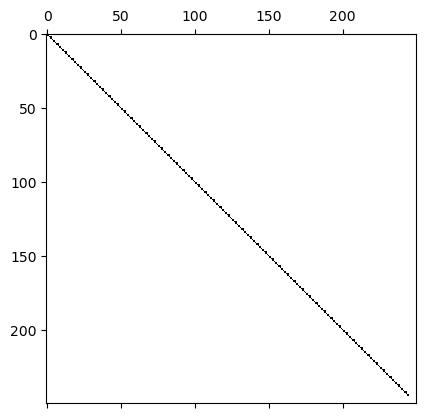

5×500 Matrix{Float64}:
    3.14159     3.04795      2.79725   …  -0.00124024   -0.00124462
    0.0        -0.0468229   -0.172727     -0.70956      -0.712286
    0.0        -6.24305    -10.4702       -0.000145413  -0.000146136
    0.0        -3.12153     -5.27205      -0.0907115    -0.0910762
 -832.407    -580.199      -41.2504       -0.121571     -0.122

In [182]:
# initial pendulum state
x0 = [pi, 0, 0, 0]
time_sim = 500
trace = run_mpc(x0, time_sim)

In [183]:
p_optimized = trace[2,:]
θ_optimized = trace[1,:]

animate_pendulum(p_optimized,θ_optimized,"mpc_pendulum")

ffmpeg version 2024-01-07-git-90bef6390f-full_build-www.gyan.dev Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.2.0 (Rev10, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --pkg-config=pkgconf --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libuavs3d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxvid --enable-libaom --enable-libjxl --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --e

Process(`ffmpeg -y -framerate 15.1515 -i tmp/mpc_pendulum_%02d.png mpc_pendulum.mp4`, ProcessExited(0))

In [125]:
trace[:,end]

5-element Vector{Float64}:
   -0.002081689444277959
    4.605885406803178
   -0.6148859486057443
    0.015515604953885528
 -164.30032689895998

In [126]:
trace[:,end-10]

5-element Vector{Float64}:
   -0.002263492106735429
    4.692603558220669
   -0.6178012688016602
    0.02340198492506002
 -165.08900473491016